In [1]:
import os, random, matplotlib, pickle, yaml
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
from glob2 import glob

SMALL_SIZE, MEDIUM_SIZE = 9, 12

In [4]:
result_path = "/Users/donghur/Desktop/Research/Murthy/BM_GPU/results/round2_legs_antennae_resnet101"

with open(f"{result_path}/INFO.yaml") as f:
    INFO = yaml.load(f, Loader=yaml.FullLoader)
    INFO_values = list(INFO.values())
    INFO_values.sort(key=lambda x: x['order'])
    
config_path = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"
with open(f"{config_path}/config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [5]:
file_key = "01BWmidfr_antmovie200929185530"
data_path = f"{result_path}/{file_key}"
global_loc_path = f"{data_path}/global_location.txt"

macro_bp = np.load(f"{data_path}/bodypoints.npy")
macro_bp_scaled = np.load(f"{data_path}/scaled_bodypoints.npy")
macro_bp_rotated = np.load(f"{data_path}/rotated_bodypoints.npy")
macro_body_orientation = np.load(f"{data_path}/body_orientation_angles.npy")
macro_angles = np.load(f"{data_path}/angles.npy")
macro_power = np.load(f"{data_path}/power.npy")
macro_embed = np.load(f"{data_path}/embeddings.npy")
macro_cluster = np.load(f"{data_path}/clusters.npy")

with open(global_loc_path, 'r') as f:
    global_loc_str = f.read()
    macro_loc = np.array([list(map(float,frame.split("\t"))) for frame in global_loc_str.split("\n")])
    macro_loc /= config["camera_scale"]

print(f"macro_angles: {macro_angles.shape}")   
print(f"macro_power: {macro_power.shape}")   
print(f"macro_embed: {macro_embed.shape}")   
print(f"macro_loc: {macro_loc.shape}")   

macro_angles: (16719, 8, 2)
macro_power: (8, 21, 16719)
macro_embed: (16719, 3)
macro_loc: (16719, 2)


/Users/donghur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/donghur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


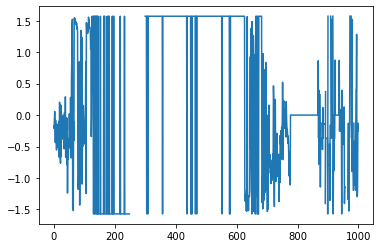

In [7]:
diff_loc = np.diff(macro_loc, axis=0)
ang_loc_change = np.arctan(diff_loc[:,1]/diff_loc[:,0])
plt.plot(ang_loc_change[1000:2000])

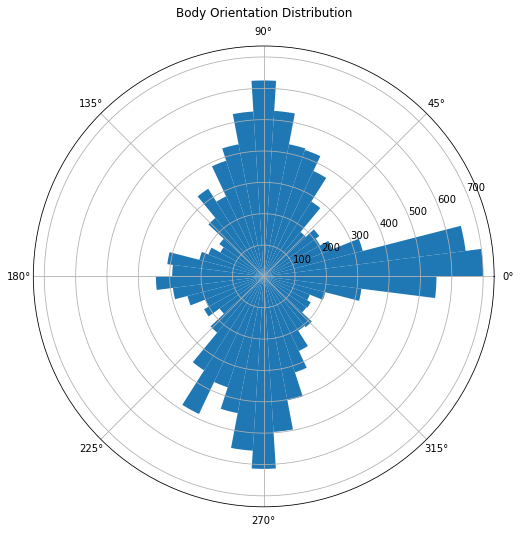

In [9]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

ax.hist(macro_body_orientation, bins=50)
ax.set(title="Body Orientation Distribution")
plt.show()

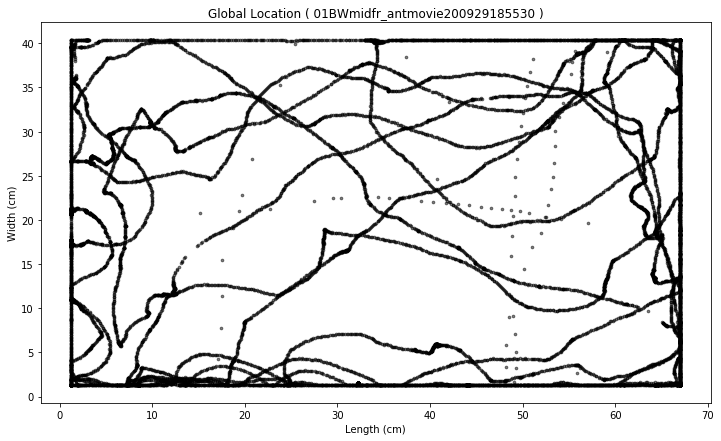

In [10]:
fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(macro_loc[:,0], macro_loc[:,1], s=7, c='k', alpha=0.5)
ax.set(xlabel='Length (cm)', ylabel='Width (cm)', title=f"Global Location ( {file_key} )")
plt.show()

In [11]:
test_macro_loc = macro_loc[:1000,:]

In [12]:
from scipy.signal import find_peaks


# (extrema,) = argrelextrema(test_macro_loc[:,0], np.greater)

peaks, _ = find_peaks(test_macro_loc[:,0], distance=10)

In [13]:
peaks

array([  2,  13,  24,  34,  49,  61,  75,  88,  99, 111, 124, 135, 147,
       166, 178, 192, 207, 226, 245, 255, 273, 283, 293, 305, 315, 327,
       339, 355, 365, 379, 391, 411, 425, 442, 458, 472, 486, 498, 526,
       543, 557, 571, 590, 615, 629, 649, 692, 729, 744, 755, 766, 778,
       795, 812, 832, 875, 896, 917, 931, 949, 972, 993])

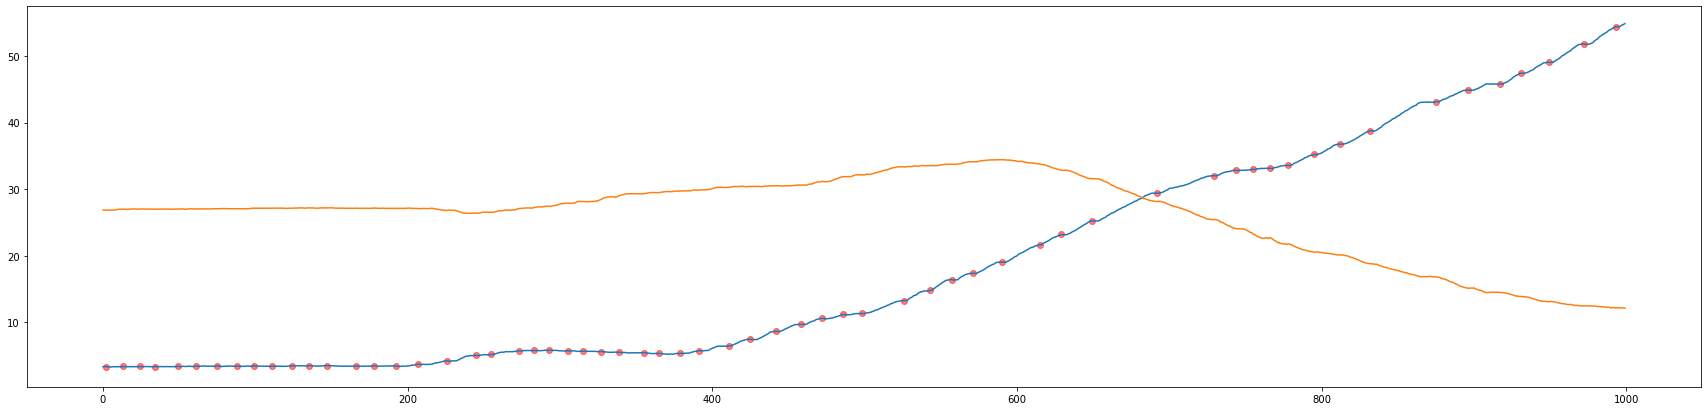

In [14]:
fig, ax = plt.subplots(figsize=(30,7))
plt.plot(test_macro_loc)
plt.scatter(peaks, test_macro_loc[peaks,0], c='r', marker="o",  alpha=0.5)
plt.show()

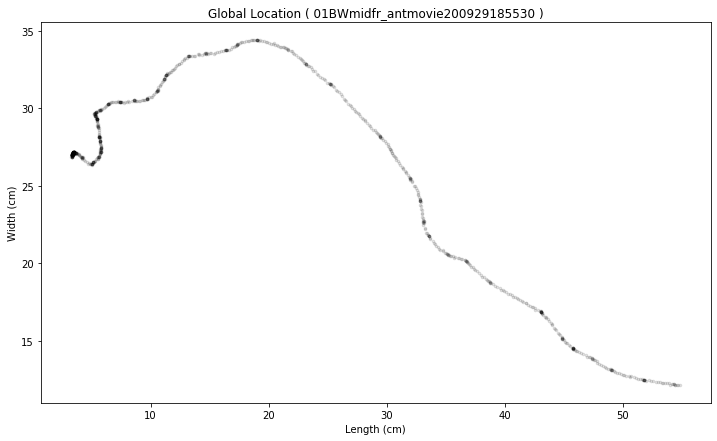

In [15]:
fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(test_macro_loc[:,0], test_macro_loc[:,1], s=7, c='k', alpha=0.1)
ax.set(xlabel='Length (cm)', ylabel='Width (cm)', title=f"Global Location ( {file_key} )")
plt.show()

In [16]:
d_macro_loc = np.abs(np.diff(macro_loc, axis=0))

wall_thresh_change = 0.2

vert_wall_idx = np.where((d_macro_loc[:,0] < wall_thresh_change) & (d_macro_loc[:,1] > wall_thresh_change))[0]
horz_wall_idx = np.where((d_macro_loc[:,1] < wall_thresh_change) & (d_macro_loc[:,0] > wall_thresh_change))[0]

print(vert_wall_idx.shape)
print(horz_wall_idx.shape)
# vert_wall_idx = wall_idx[dim_idx == 0]
# hor_wall_idx = wall_idx[dim_idx == 1]

(243,)
(642,)


In [17]:
macro_loc.shape


(16719, 2)

In [18]:
horz_wall_idx = np.where((d_macro_loc[:,0] > 1000*d_macro_loc[:,1]))[0]
vert_wall_idx = np.where((d_macro_loc[:,1] > 1000*d_macro_loc[:,0]))[0]

print(vert_wall_idx.shape)
print(horz_wall_idx.shape)

(3062,)
(2793,)


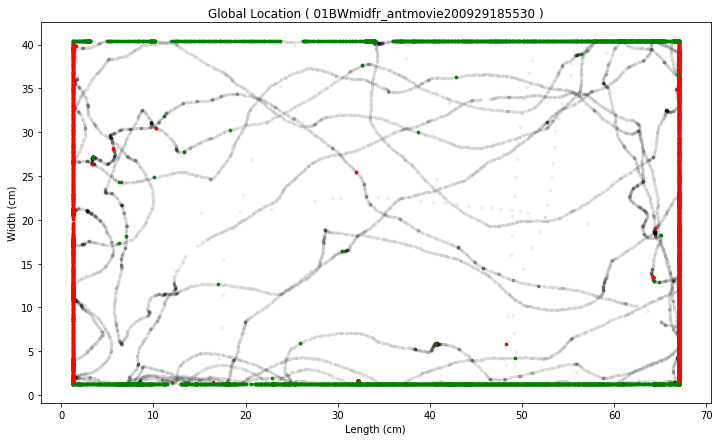

In [19]:
fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(macro_loc[:,0], macro_loc[:,1], s=7, c='k', alpha=0.05)
ax.scatter(macro_loc[vert_wall_idx,0], macro_loc[vert_wall_idx,1], s=7, c='r', alpha=1)
ax.scatter(macro_loc[horz_wall_idx,0], macro_loc[horz_wall_idx,1], s=7, c='g', alpha=1)
ax.set(xlabel='Length (cm)', ylabel='Width (cm)', title=f"Global Location ( {file_key} )")
plt.show()

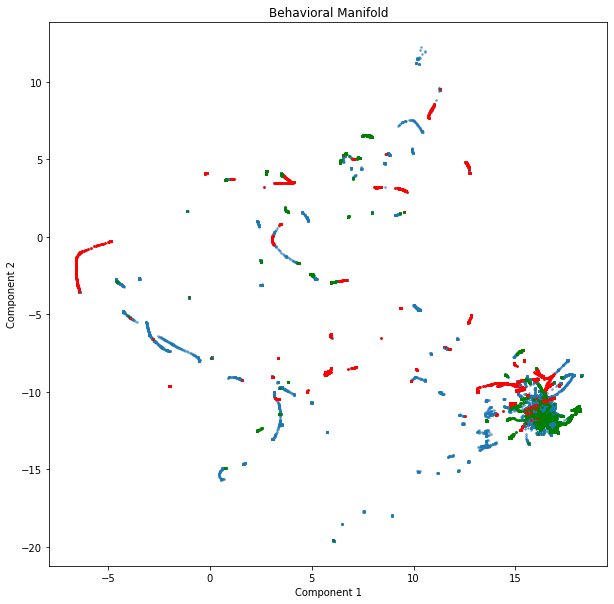

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(macro_embed[:,0], macro_embed[:,1], alpha=0.5, s=3)  
ax.scatter(macro_embed[vert_wall_idx,0], macro_embed[vert_wall_idx,1], c='r', alpha=1, s=3)  
ax.scatter(macro_embed[horz_wall_idx,0], macro_embed[horz_wall_idx,1], c='g', alpha=1, s=3)  

ax.set(xlabel='Component 1', ylabel='Component 2', title="Behavioral Manifold")
plt.show()